In [1]:
# Parameters
provider = "X"
hyperparameter_tuning = False


In [2]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from math import log, floor
from fbprophet import Prophet
import matplotlib as mpl
import matplotlib.dates as mdates
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import datetime
from fbprophet.diagnostics import cross_validation, performance_metrics 
import os
import warnings

try:
    from src import CustomProphetModel
    from src import ProjectConstants
except ModuleNotFoundError:
    os.chdir("../..")
    from src import CustomProphetModel
    from src import ProjectConstants

ROOT_DIR = ProjectConstants.ROOT_DIR

warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (25,10)
sns.set_theme(style="whitegrid")
print(os.getcwd())

/Users/berkay.gokova/Code/budget_tracking/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/Users/berkay.gokova/Code/budget_tracking


In [3]:

import os
import sys

import pandas as pd
from fbprophet import Prophet


# from https://stackoverflow.com/questions/11130156/suppress-stdout-stderr-print-from-python-functions
class suppress_stdout_stderr(object):
    '''
    A context manager for doing a "deep suppression" of stdout and stderr in
    Python, i.e. will suppress all print, even if the print originates in a
    compiled C/Fortran sub-function.
       This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through).

    '''
    def __init__(self):
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        self.save_fds = (os.dup(1), os.dup(2))

    def __enter__(self):
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        os.close(self.null_fds[0])
        os.close(self.null_fds[1])


In [4]:
def time_binning(dataframe, col, step, cycle_adjustment_constant=None):
    max_val = dataframe[col].max()
    min_val = dataframe[col].min()
    bin_interval = (max_val - min_val)
    if cycle_adjustment_constant:
        bin_interval += 1
    bins = int(bin_interval / step)
    print("Max value: ", max_val)
    print("Min value: ", min_val)
    print("Bin value: ", bins)
    assert bin_interval % step == 0, "Interval value cannot be divided by the step param"
    f = np.arange(min_val, max_val, step)
    l = np.arange(min_val + step, max_val + step, step)
    labels = [f"{v1} - {v2}" for v1, v2 in zip(f, l)]
    return pd.cut(dataframe[col], bins=bins, labels=labels)


In [5]:
def human_format(number, is_str=False):
    if is_str:
        number = number.replace("−", "-")

    if number <= 0:
        return str(number)
        
    units = ['', 'K', 'M', 'G', 'T', 'P']
    k = 1000.0
    magnitude = int(floor(log(number, k)))
    return '%.1f%s' % (number / k**magnitude, units[magnitude])

In [6]:
def reformat_yticklabels(ax):
    labels = [human_format(item.get_position()[1]) for item in ax.get_yticklabels()]
    return labels

def plot_reformat_decorator(func):
    def wrapper():
        fig, ax = plt.subplots()
        func(ax)
        fig.canvas.draw()
        labels = reformat_yticklabels(ax)
        ax.set_yticklabels(labels)
        return ax
    return wrapper

In [7]:
def read_base_df():
    dataframe = pd.read_csv("data/provider_data.csv")
    dataframe.rename(columns={"Total_payment_amount": "amount"}, inplace=True)
    dataframe["date"] = dataframe.date + " " + dataframe.hour.astype(str).str.zfill(2) + ":00"
    dataframe["date"] = pd.to_datetime(dataframe["date"])
    dataframe["day"] = dataframe["date"].dt.strftime("%a")
    dataframe["month"] = dataframe["date"].dt.strftime("%m").astype(int)
    dataframe["hour_string"] = dataframe["date"].dt.strftime("%X")
    return dataframe

df = read_base_df()
df.head()

,date,hour,provider,amount,day,month,hour_string
0,2022-01-08,0,flynas,1391.58,Sat,1,00:00:00
1,2022-01-08,0,IATA_enuygun,96659.91,Sat,1,00:00:00
2,2022-01-08,0,IATA_weg,2047.05,Sat,1,00:00:00
3,2022-01-08,0,pegasus,38642.98,Sat,1,00:00:00
4,2022-01-08,0,sunexpress,25719.43,Sat,1,00:00:00


In [9]:
print("Earliest date: ", df.date.min())
print("Latest date: ", df.date.max())

Earliest date:  2022-01-08 00:00:00
Latest date:  2023-02-06 23:00:00


In [10]:
def filter_out_provider(dataframe):
    df_provider = dataframe.query(f"provider == '{provider}'")
    df_provider = df_provider.set_index("date").asfreq(freq="1h").reset_index()
    df_provider["hour"] = df_provider["date"].dt.hour
    df_provider["month"] = df_provider["date"].dt.month
    df_provider["day"] = df_provider["date"].dt.strftime("%a")
    df_provider["hour_string"] = df_provider["date"].dt.strftime("%X")
    df_provider["hour_bin"] = time_binning(df_provider, "hour", 3, cycle_adjustment_constant=1)
    # df_provider["month_bin"] = time_binning(df_provider, "month", 2)
    df_provider["provider"] = provider
    # df_provider["amount"] = df_provider["amount"].interpolate(method="linear")
    df_provider.dropna(subset=["amount"], inplace=True)
    return df_provider
df_provider = filter_out_provider(df)

Max value:  23
Min value:  0
Bin value:  8


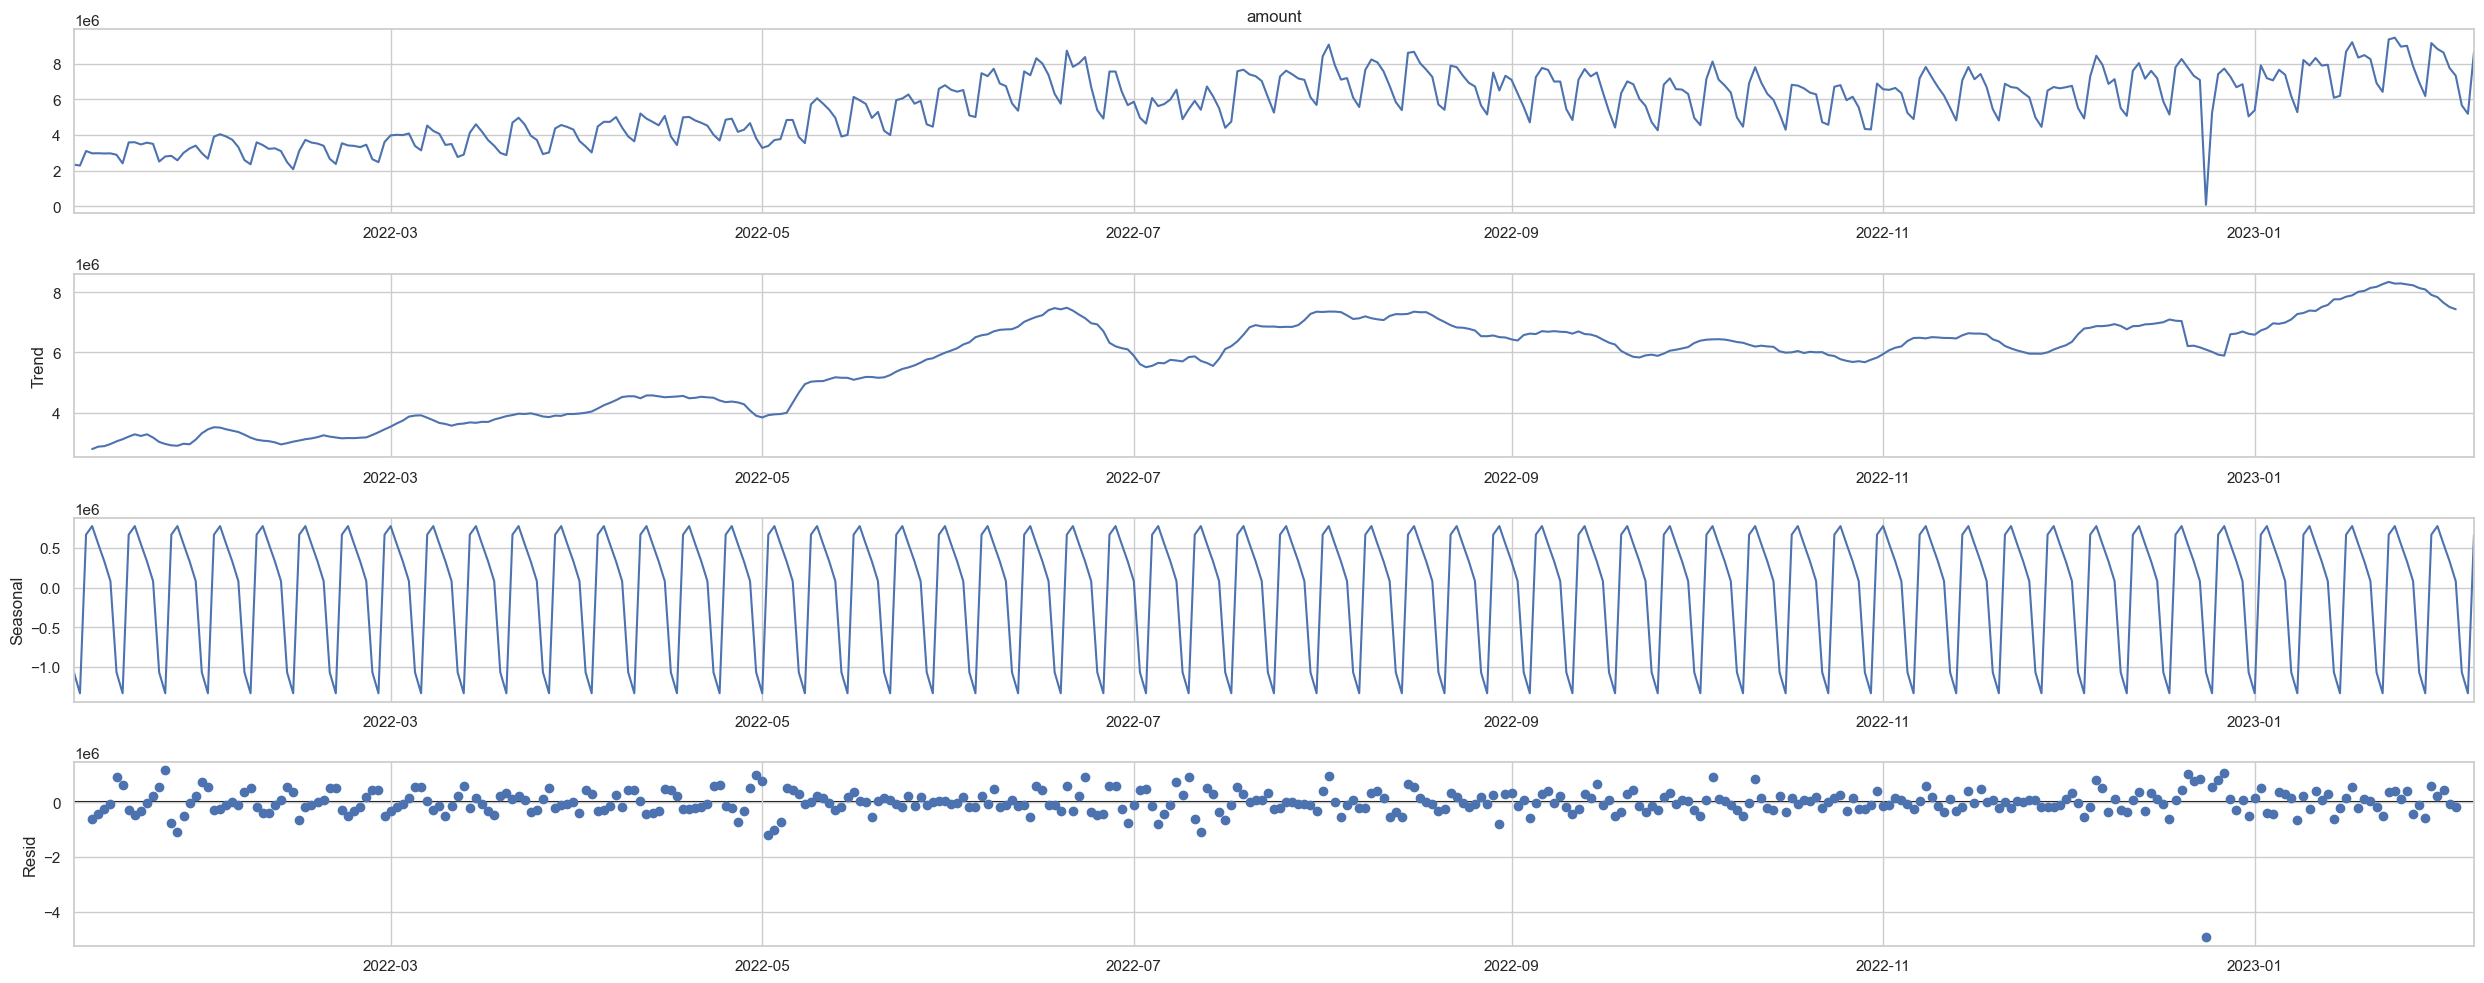

In [12]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
df_decomp = df_provider.set_index("date").resample("D").sum()["amount"]
seasonal_decomp = seasonal_decompose(df_decomp, model="additive", period=7)
seasonal_decomp.plot();

<AxesSubplot: xlabel='date'>

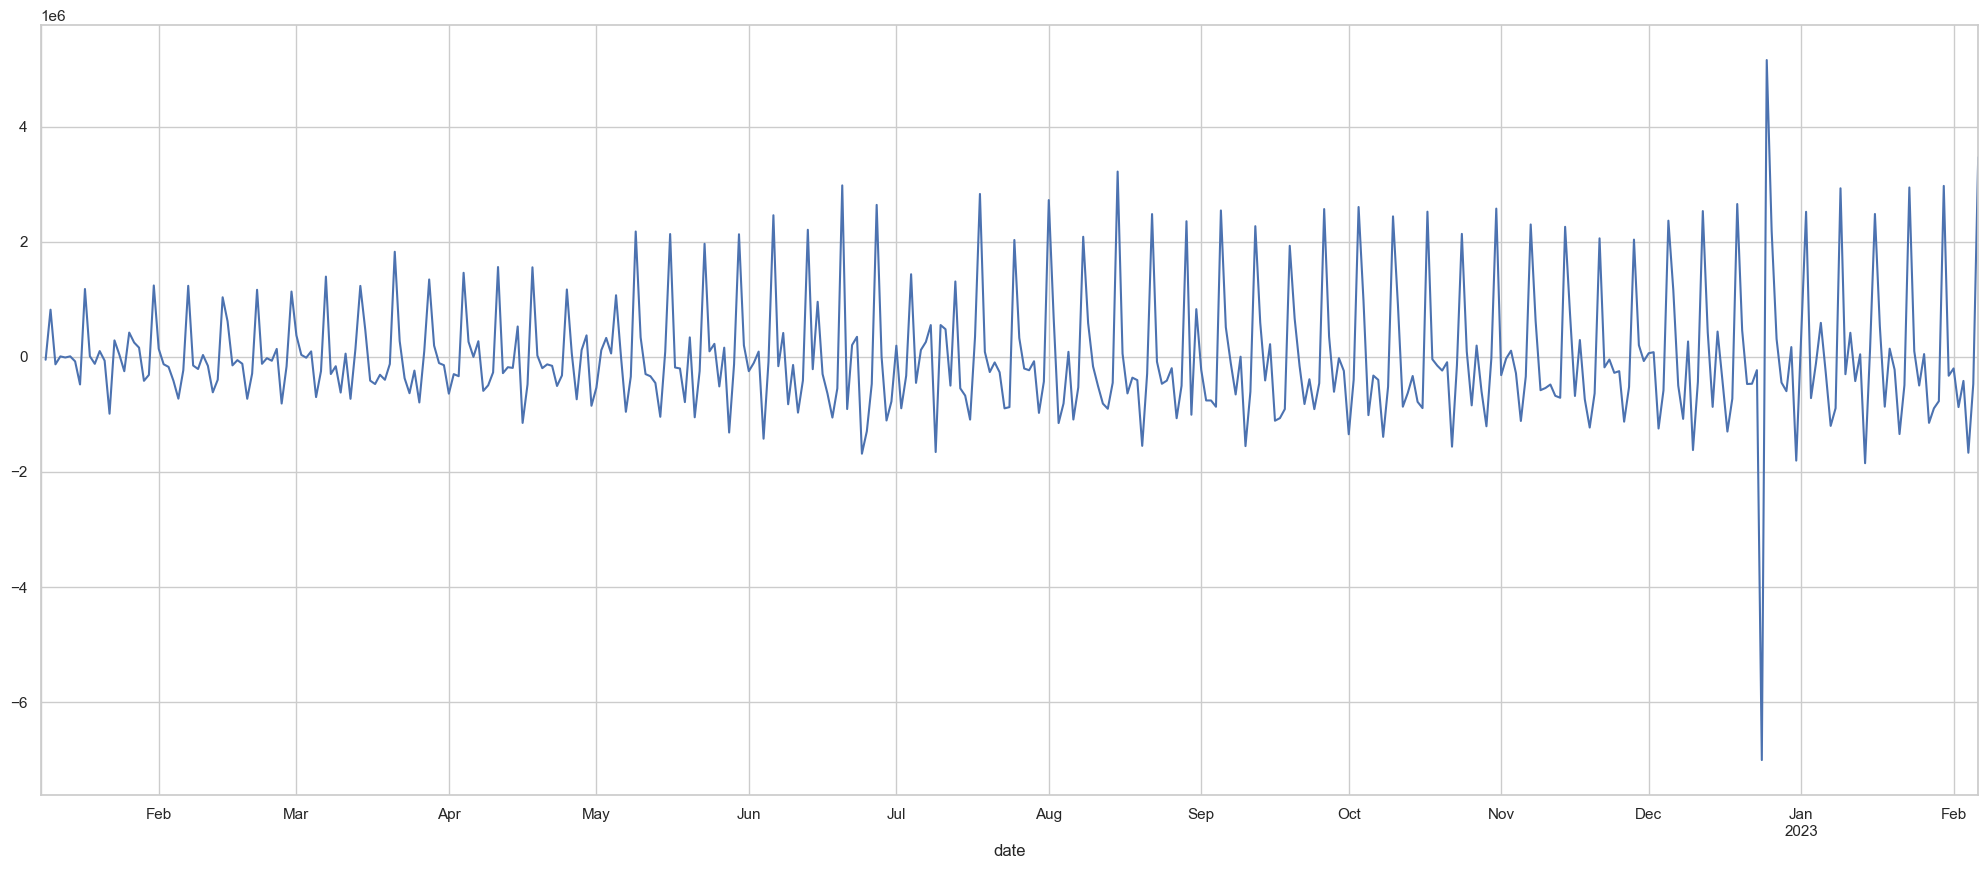

In [13]:
df_decomp.diff().plot()

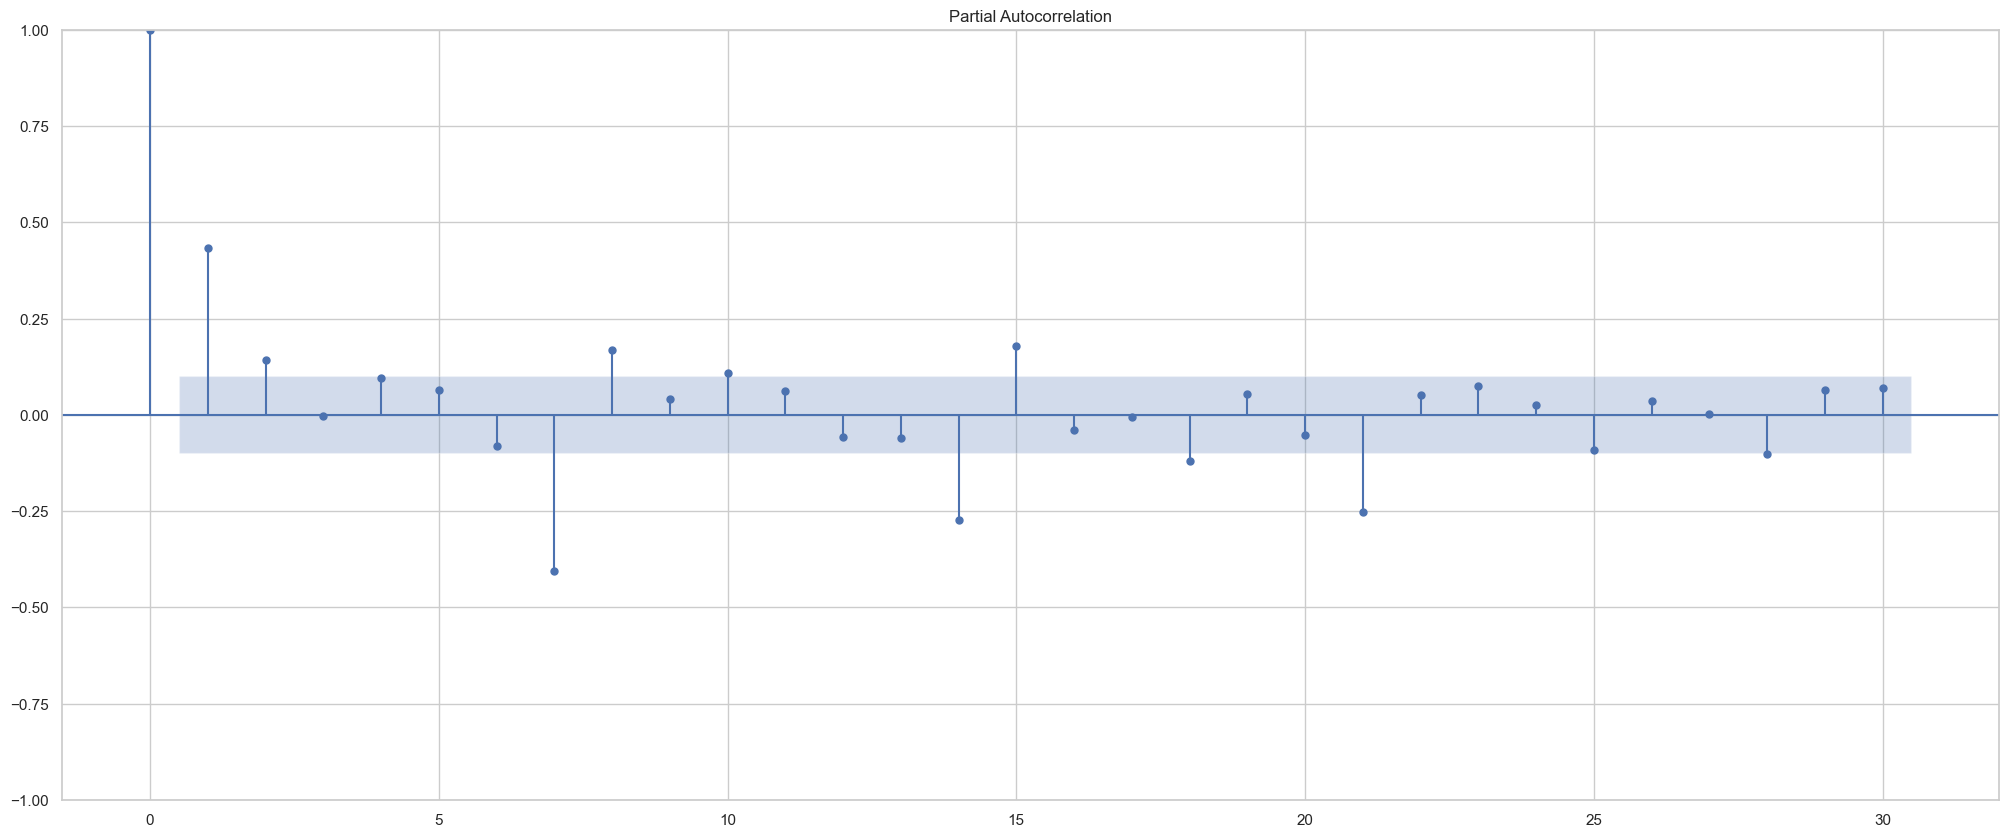

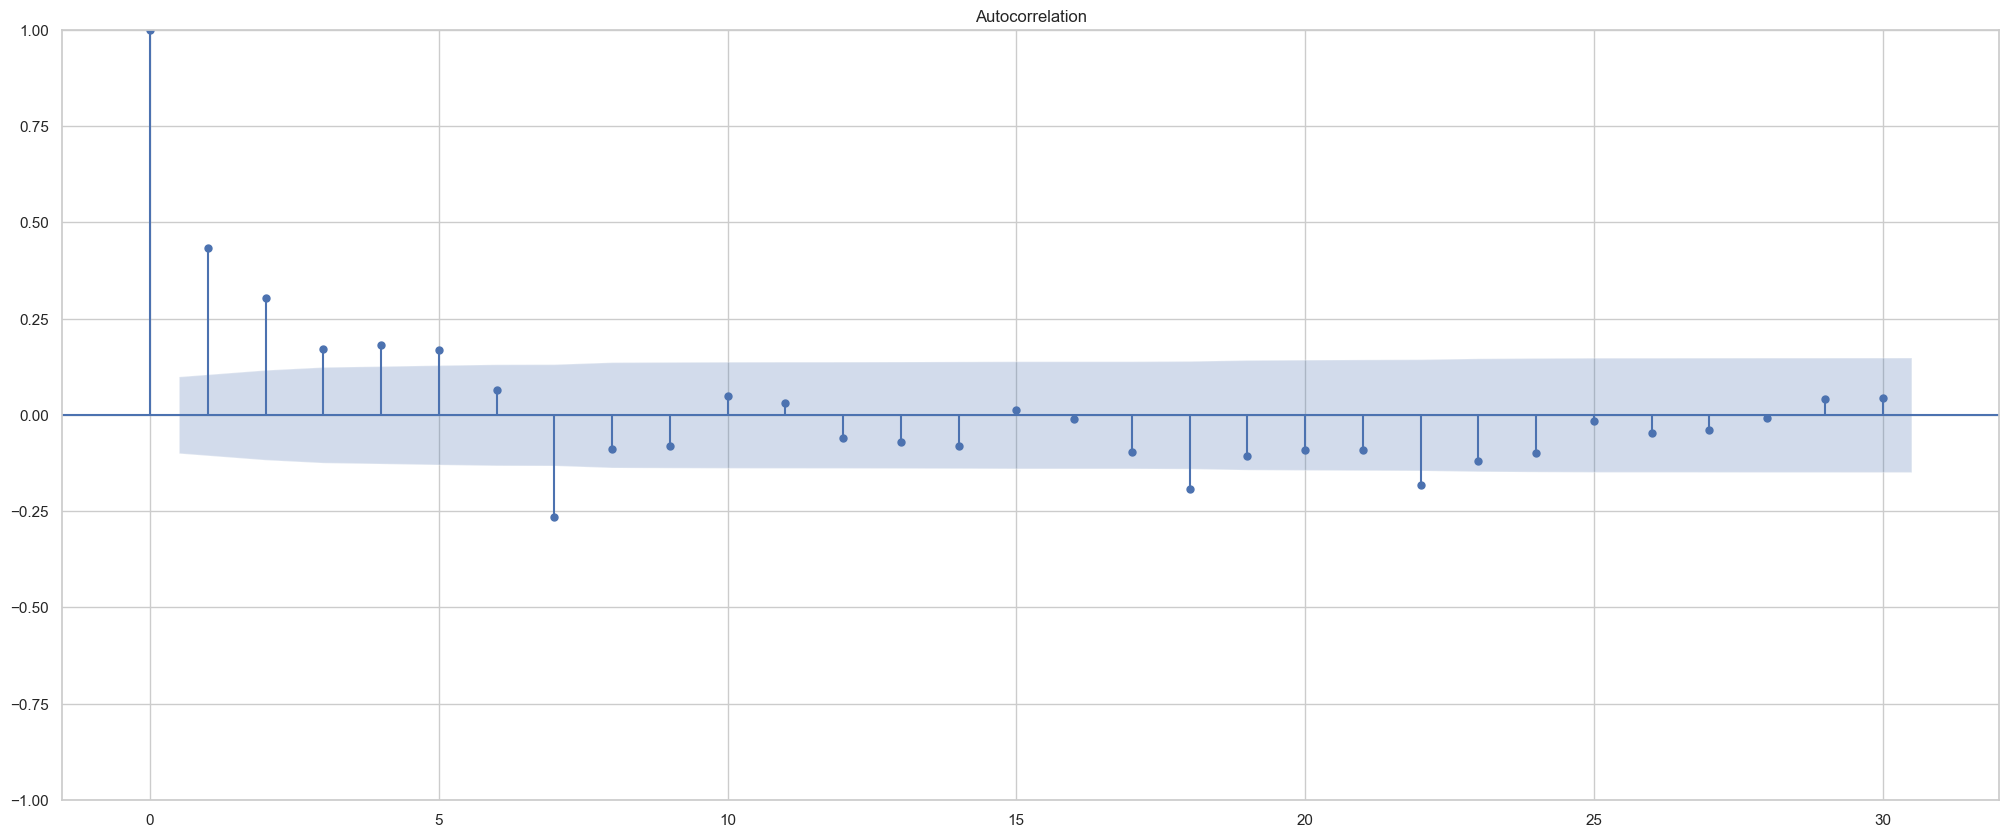

In [14]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
plot_pacf(df_decomp.diff(7).dropna(), lags = 30);
plot_acf(df_decomp.diff(7).dropna(), lags = 30);

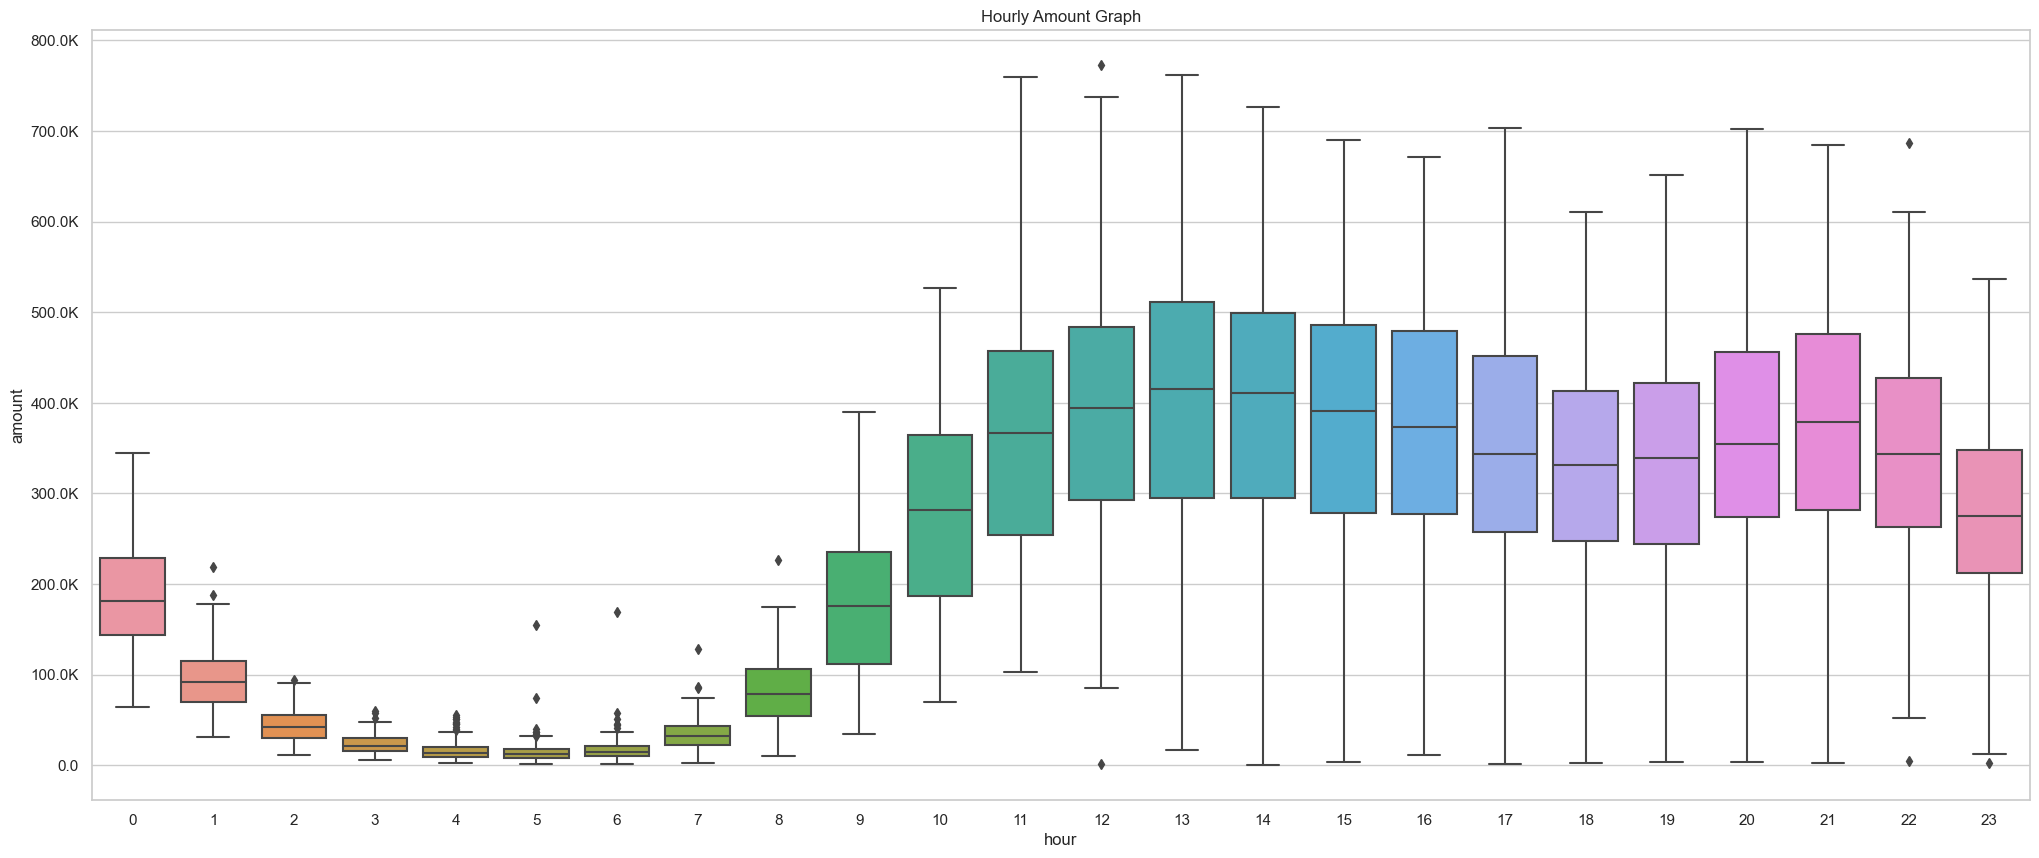

In [15]:
@plot_reformat_decorator
def draw_hour_amount(ax):
    sns.boxplot(x="hour", y="amount", data=df_provider, ax=ax)
    plt.title("Hourly Amount Graph")
draw_hour_amount();

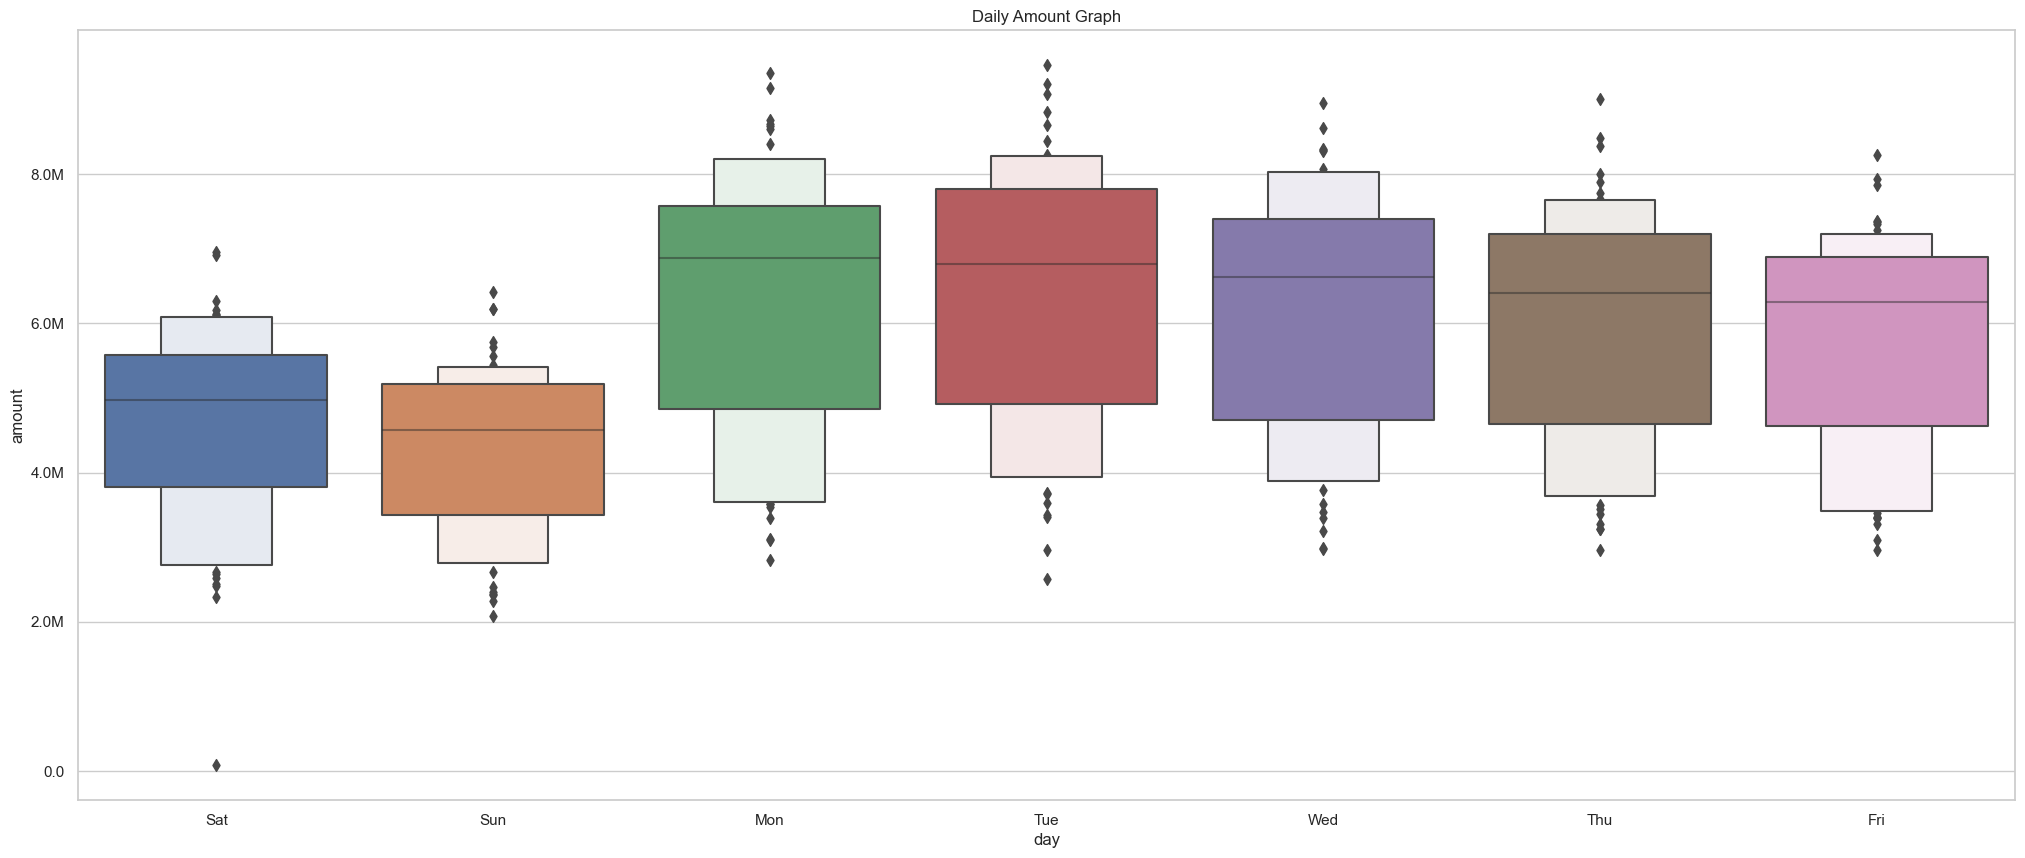

In [17]:
@plot_reformat_decorator
def draw_daily_amount(ax):
    z = df_provider.set_index("date").resample("D").agg({
    "day": "last",
    "month": "last",
    "amount": "sum"
        }).reset_index()
    sns.boxenplot(x="day", y="amount", data=z, ax=ax);
    plt.title("Daily Amount Graph")

draw_daily_amount();

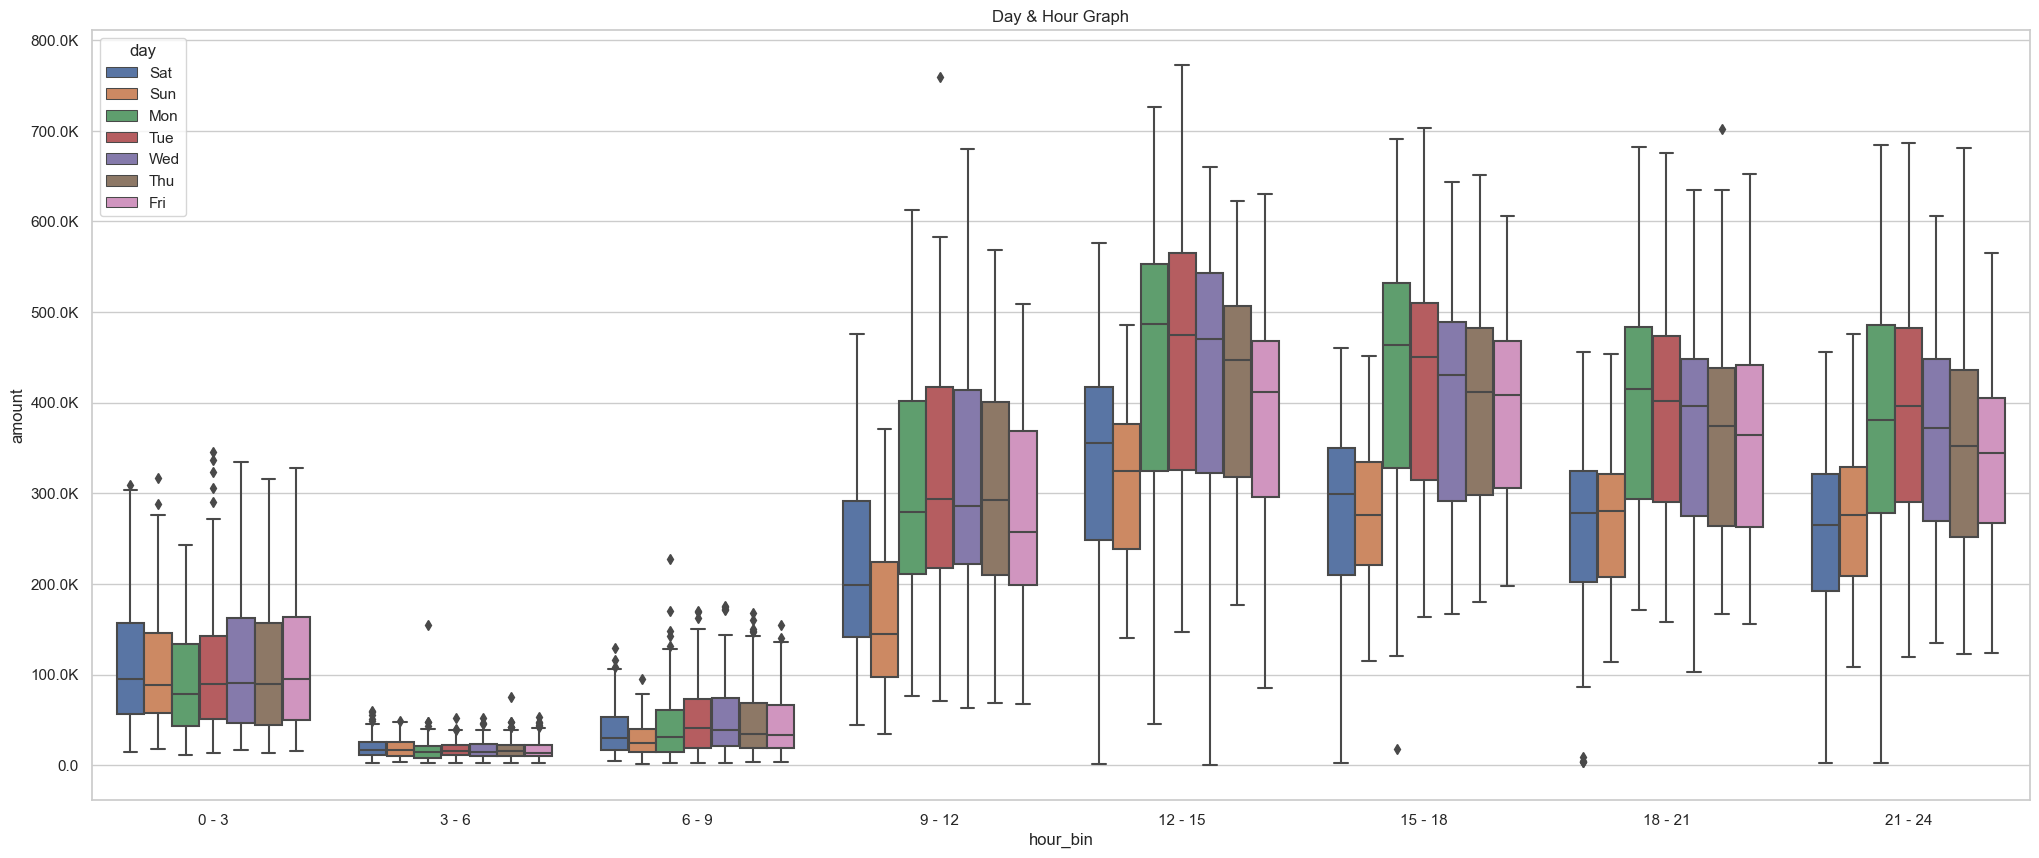

In [18]:
@plot_reformat_decorator
def draw_day_hour_amount(ax):
    sns.boxplot(x="hour_bin", y="amount", data=df_provider, hue="day", ax=ax)
    plt.title("Day & Hour Graph")
draw_day_hour_amount();

<AxesSubplot: title={'center': 'Monthly Total Graph'}, xlabel='month', ylabel='amount'>

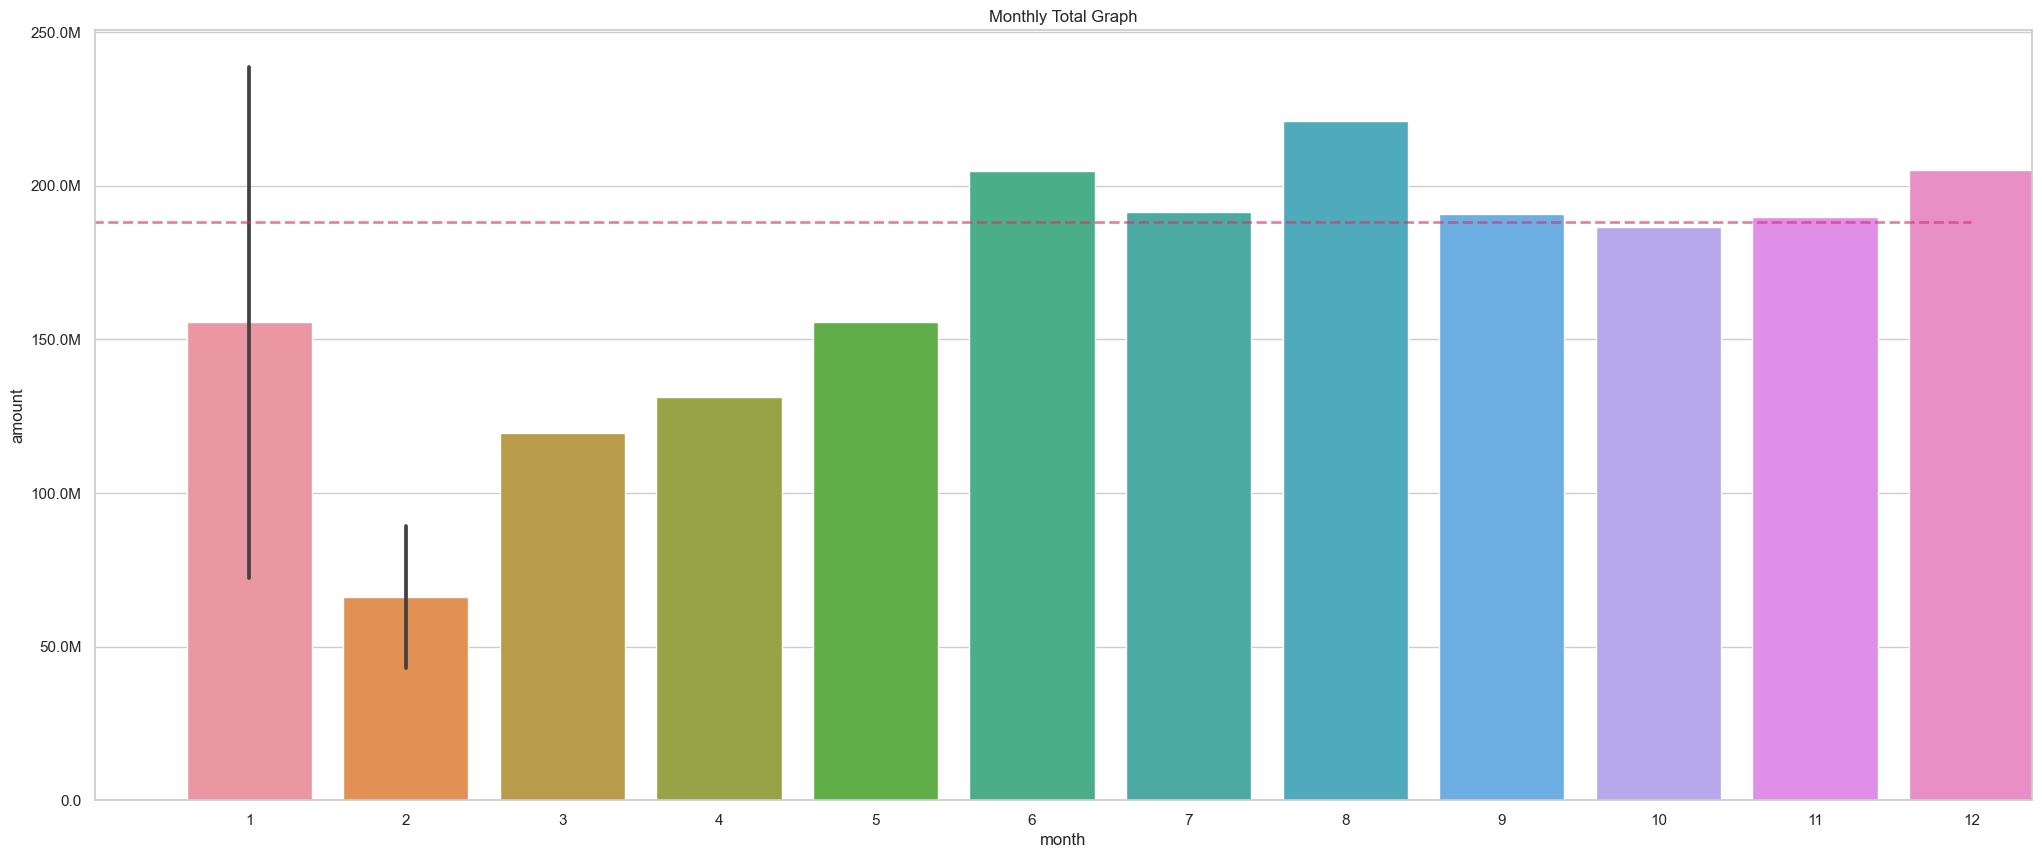

In [19]:
@plot_reformat_decorator
def draw_month_amount(ax):
    dataframe = df_provider.set_index("date").resample("M").agg({
        "day": "last",
        "month": "last",
        "amount": "sum"
    }).reset_index()
    sns.barplot(x="month", y="amount", data=dataframe, ax=ax)
    plt.title("Monthly Total Graph")
    plt.hlines(y=dataframe.amount.median(),
               xmin=-1,
               xmax=11,
               linewidth=2,
               alpha=0.6,
               linestyles="--",
               colors="#D23369"
               )
    plt.margins(x=-0.001)


draw_month_amount()


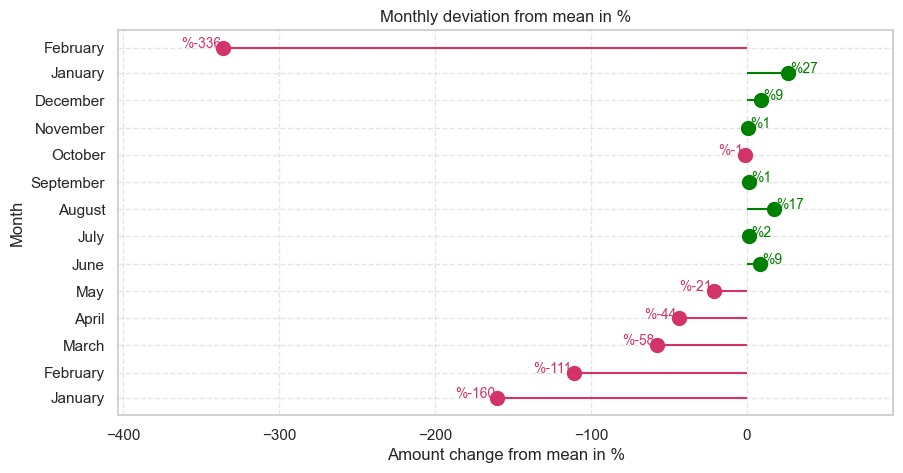

In [20]:
z = df_provider.groupby(pd.Grouper(key="date", freq="M")).amount.sum().to_frame()
z["pct_change"] = z.apply(lambda x: (x.amount - z.amount.median()) / min(x.amount, z.amount.median()) * 100, axis=1)
z["pct_change"] = z["pct_change"].replace(-np.inf, 0)
z["pct_change"] = z["pct_change"].replace(np.inf, 0)
z["pct_str"] = z["pct_change"].map(lambda x: "%" + str(round(x)))
z.sort_index(ascending=True, inplace=True)
colors = ["#D23369" if x < 0 else "green" for x in z["pct_change"]]

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()
ax.hlines(y = z.index, xmin = 0 , color = colors,  xmax = z["pct_change"], linewidth = 1.5)

for x, y in zip(z["pct_change"], z.index):

    ax.text(x - (z["pct_change"].max() * 0.05) if x < 0 else x + (z["pct_change"].max() * 0.05), 
             y, 
             "%" + str(round(x)), 
             color = "#D23369" if x < 0 else "green",  
             horizontalalignment='right' if x < 0 else 'left', 
             size = 10)

    ax.scatter(x, 
                y, 
                color = "#D23369" if x < 0 else "green", 
                alpha = 1,
                s=100
                )

ax.set_xlabel("Amount change from mean in %")
ax.set_ylabel("Month")
ax.set_title("Monthly deviation from mean in %")

ax.grid(linestyle='--', alpha=0.5)
ax.set_yticks(z.index);
ax.set_xlim(z["pct_change"].min() - (abs(z["pct_change"].min()) * 0.2), z["pct_change"].max() + (abs(z["pct_change"].min()) * 0.2))
ax.set_yticklabels(z.index.strftime("%B"));

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


0    390
1      5
Name: anomaly, dtype: int64
The MAE for the model is 295507.74166021735
The MAPE for the model is 0.2195033910821326


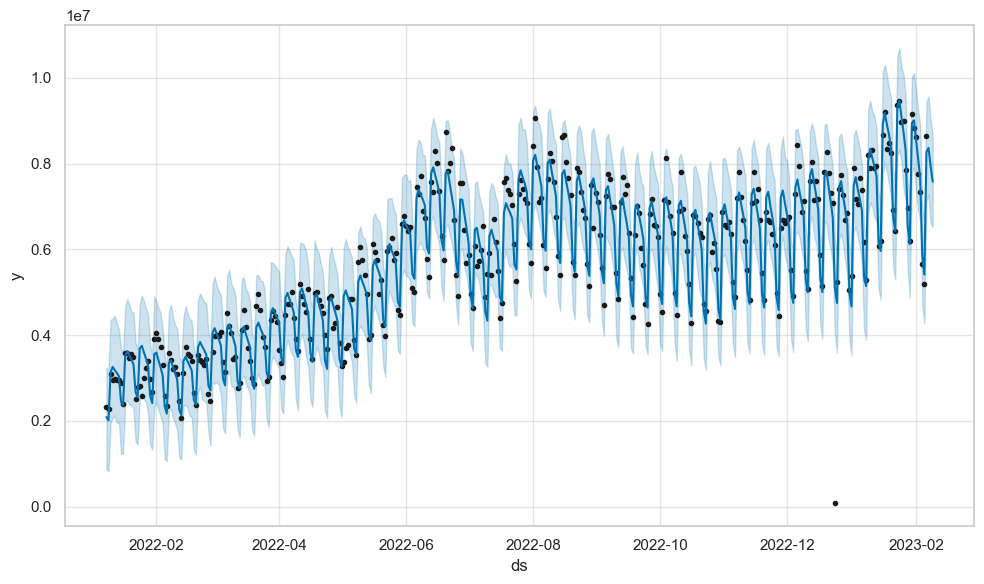

In [21]:
n_test = 3
fb_train = df_provider.set_index("date").resample("D").sum()[["amount"]].reset_index().rename(columns={"date": "ds", "amount": "y"})#.iloc[:-n_test]
m = CustomProphetModel(provider)

with suppress_stdout_stderr():
    m.fit(fb_train)
    future = m.make_future_dataframe(periods=n_test, freq="D")
    forecast_train = m.predict(future)
# forecast_test = m.predict(fb_test)

m.plot(forecast_train);
# Merge actual and predicted values
performance = pd.merge(fb_train, forecast_train[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')

# Create an anomaly indicator
performance['anomaly'] = performance.apply(lambda rows: 1 if ((rows.y < rows.yhat_lower)|(rows.y > rows.yhat_upper)) else 0, axis = 1)

# Check the number of anomalies
print(performance['anomaly'].value_counts())

# Check MAE value
performance_MAE = mean_absolute_error(performance['y'], performance['yhat'])
print(f'The MAE for the model is {performance_MAE}')
# Check MAPE value
performance_MAPE = mean_absolute_percentage_error(performance['y'], performance['yhat'])
print(f'The MAPE for the model is {performance_MAPE}')


In [22]:
# test period
horizon = '1 days'

# itraining period (optional. default is 3x of horizon)
initial = '365 days'  

# spacing between cutoff dates (optional. default is 0.5x of horizon)
period = '1 days'
with suppress_stdout_stderr():
    try:
        df_cv = cross_validation(m, initial=initial, period=period, horizon=horizon, parallel='processes')
    except ValueError:
        df_cv = cross_validation(m, initial=f"{fb_train.shape[0] - 20} days", period=period, horizon=horizon, parallel='processes')

INFO:fbprophet:Making 29 forecasts with cutoffs between 2023-01-08 00:00:00 and 2023-02-05 00:00:00


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x138c62df0>


In [23]:
df_metrics = performance_metrics(df_cv)  # can define window size, e.g. rolling_window=365

In [24]:
df_metrics = performance_metrics(df_cv)  # can define window size, e.g. rolling_window=365
import json
with open(ROOT_DIR + "/product/metrics/performance_results.json", "r") as rd:
    conf_js = json.load(rd)

with open(ROOT_DIR + "/product/metrics/performance_results.json", "w") as wr:
    conf_js.update({provider : df_metrics.drop(columns=["horizon"]).assign(latest_date=m.history_dates.max().strftime("%d-%m-%Y")).to_dict("records")})
    json.dump(conf_js, wr, indent=4)

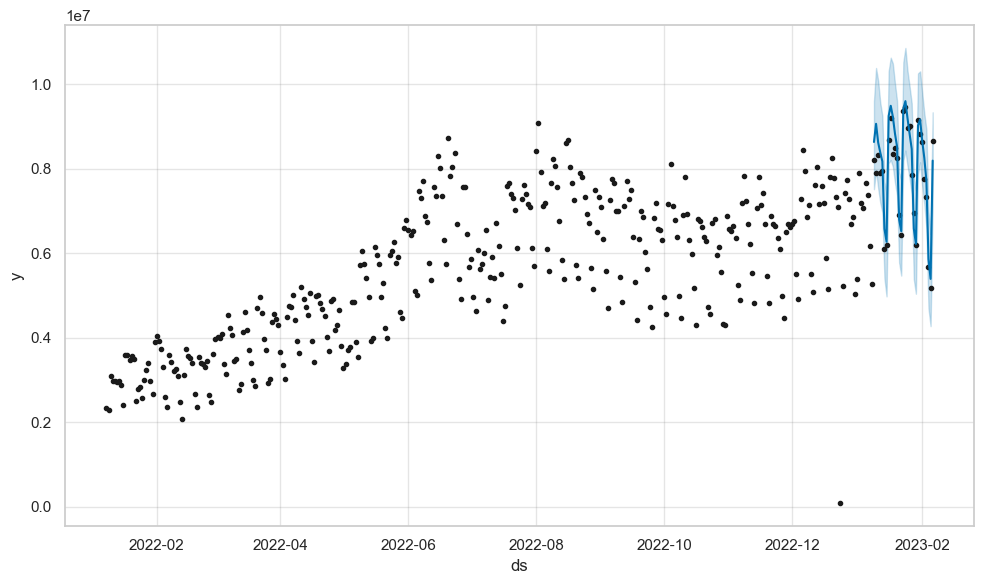

In [25]:
m.plot(df_cv);

In [26]:
def draw_model(cv_data):
    performance = pd.merge(fb_train, cv_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')

    # Create an anomaly indicator
    performance['anomaly'] = performance.apply(lambda rows: 1 if ((rows.y < rows.yhat_lower)|(rows.y > rows.yhat_upper)) else 0, axis = 1)

    # Check the number of anomalies
    print(performance['anomaly'].value_counts())

    # Check MAE value
    performance_MAE = mean_absolute_error(performance['y'], performance['yhat'])
    print(f'The MAE for the model is {performance_MAE}')
    # Check MAPE value
    performance_MAPE = mean_absolute_percentage_error(performance['y'], performance['yhat'])
    print(f'The MAPE for the model is {performance_MAPE}')

    palette ={1: "crimson", 0: "C0"}
    fig, ax = plt.subplots()
    sns.scatterplot(x='ds', y='y', data=performance, hue='anomaly', ax=ax, palette=palette)
    sns.lineplot(x='ds', y='yhat', data=performance, color='black', ax=ax, alpha=0.5)
    # ax.xaxis.set_major_locator(mpl.dates.MonthLocator())
    # ax.xaxis.set_minor_locator(mpl.dates.MonthLocator(bymonthday=15))
    # ax.xaxis.set_major_formatter(plt.NullFormatter())
    # ax.xaxis.set_minor_formatter(mpl.dates.DateFormatter('%B-%d'));
    for idx, val in performance.iterrows():
        if val["anomaly"] == 1:
            if  val["ds"] != pd.Timestamp(year=2022, month=5, day=2) and val["ds"] != pd.Timestamp(year=2022, month=5, day=4) and val["ds"] != pd.Timestamp(year=2022, month=7, day=10):
                # ax.annotate(val["ds"], (idx, val["y"] + 0.2))
                ax.annotate(val["ds"].strftime("%d-%b %A"), (mdates.date2num(val["ds"]), 8000), xytext=(15, 15), 
                    textcoords='offset pixels', 
                    # arrowprops=dict(arrowstyle='-|>'),
                    rotation=90)
                ax.vlines(mdates.date2num(val["ds"]), ymax=fb_train.y.max() + 100000, ymin=0, color="C1", linestyles="dashed")

    ax.legend().set_visible(False)
    return fig

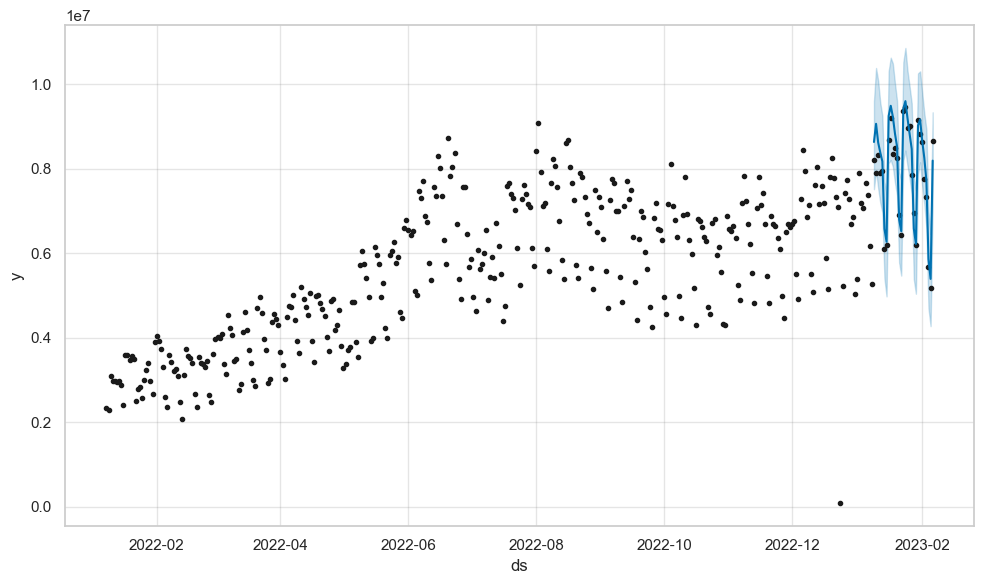

In [27]:
m.plot(df_cv);

0    28
1     1
Name: anomaly, dtype: int64
The MAE for the model is 331064.61942046613
The MAPE for the model is 0.04238524918742676


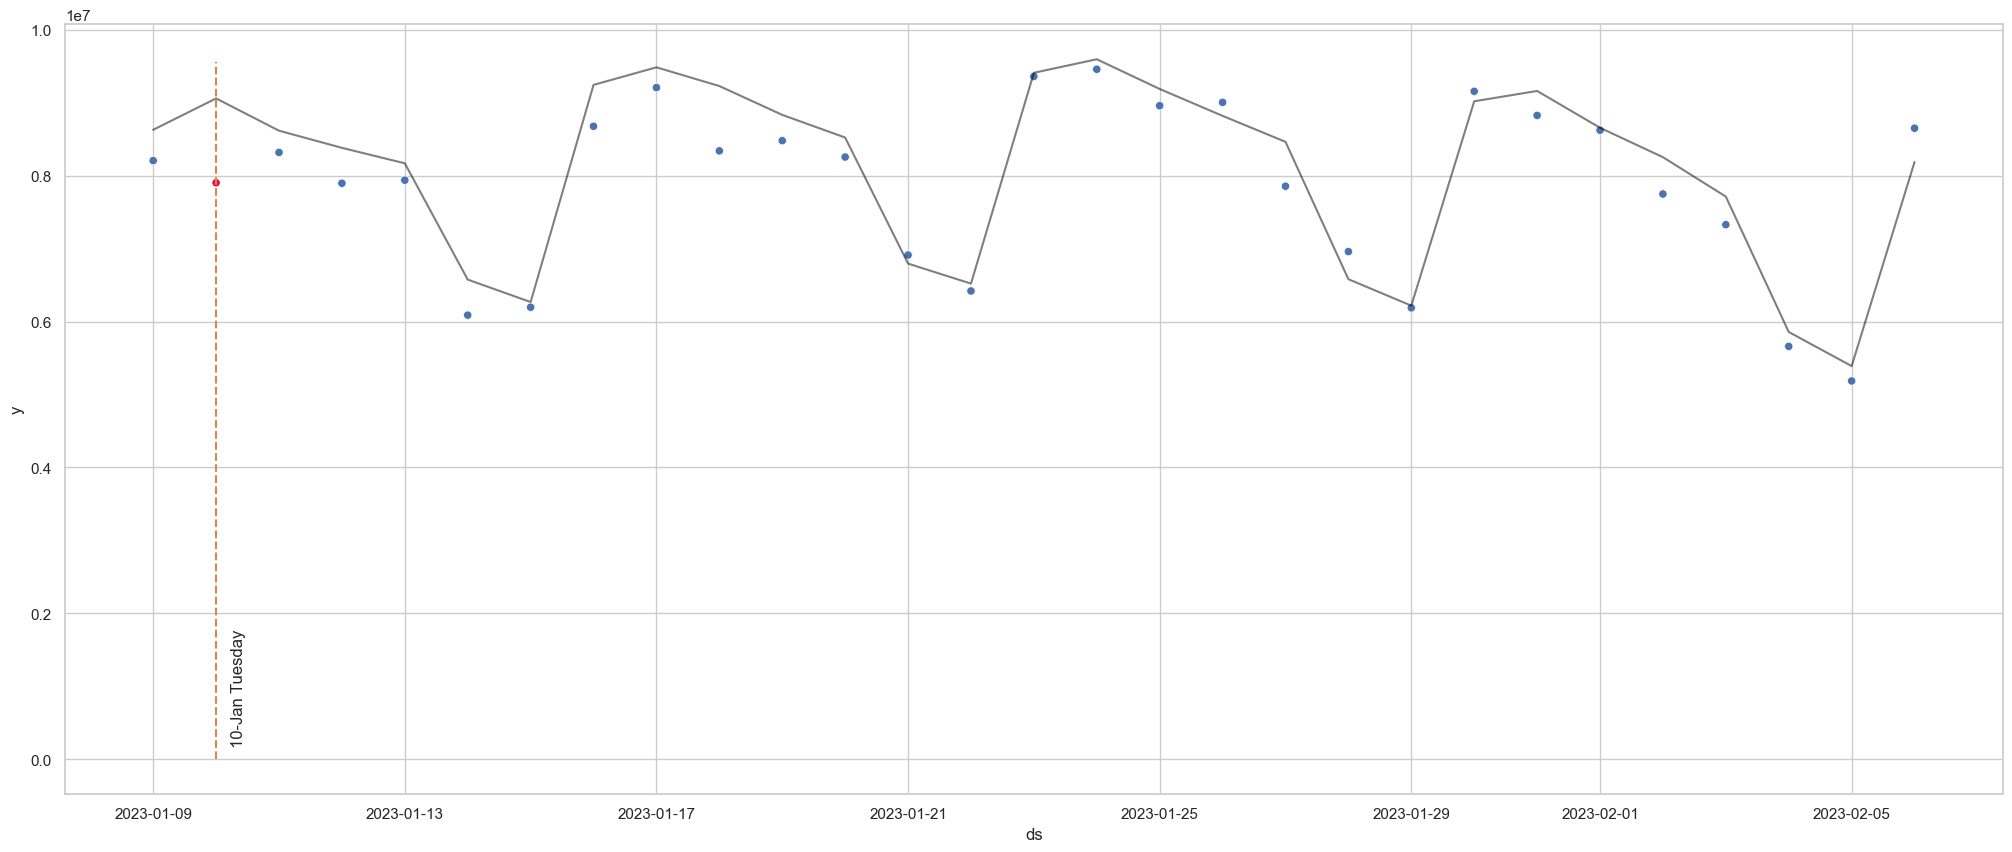

In [28]:
draw_model(cv_data=df_cv);

In [29]:
if hyperparameter_tuning:
    from mlflow import log_metric, log_param, log_artifacts
    import mlflow

    mlflow.set_experiment(provider)
    experiment = mlflow.get_experiment_by_name(provider).experiment_id
    from sklearn.model_selection import ParameterGrid
    import random
    params_grid = {'seasonality_mode':['multiplicative'],
                    "yearly_seasonality": [True],
                    'changepoint_prior_scale':[0.05, 0.3, 0.85],
                #   'n_changepoints' : [100,150,200],
                    "changepoint_range": [0.1, 0.5, 0.9],
                    "weekly_fourier": [5, 30, 85],
                    "weekly_prior": [5, 30, 85],
                }
    grid = ParameterGrid(params_grid)
    cnt = 0
    for p in grid:
        cnt = cnt+1

    print('Total Possible Models',cnt)
    metrics = pd.DataFrame()

    model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])
    for idx, p in enumerate(grid):
        test = pd.DataFrame()
        print(idx, "/", p)
        print(p)
        random.seed(0)
        train_model = Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                            #  n_changepoints = p['n_changepoints'],
                            seasonality_mode = p['seasonality_mode'],
                            weekly_seasonality=False,
                            daily_seasonality=False,
                            yearly_seasonality=p["yearly_seasonality"],
                            interval_width=0.99).add_seasonality(
                                            name='weekly',
                                            period=7,
                                            fourier_order=p['weekly_fourier'],
                                            prior_scale=p['weekly_prior'],
                                            mode="multiplicative"
                                            )
        with suppress_stdout_stderr():
            train_model.fit(fb_train)
            df_cv = cross_validation(train_model, initial=initial, period=period, horizon=horizon, parallel='processes')
            df_metrics = performance_metrics(df_cv, metrics=["mape", "mdape", "mae", "rmse"])
            df_metrics["params"] = str(p)
            metrics = pd.concat([metrics, df_metrics])

        
        with mlflow.start_run(experiment_id=experiment):
            ARTIFACT_PATH = "model"
            # mlflow.prophet.log_model(train_model, artifact_path=ARTIFACT_PATH)
            mlflow.log_params(p)
            mlflow.log_metrics(df_metrics.drop(columns=["params", "horizon"]).iloc[0].to_dict())
            model_uri = mlflow.get_artifact_uri(ARTIFACT_PATH)
            fig1 = draw_model(df_cv)
            fig2 = train_model.plot(df_cv)
            mlflow.log_figure(fig1, 'fig1.png')
            mlflow.log_figure(fig2, 'fig2.png')
            
    display(metrics.sort_values("mdape").head(1).to_dict())

In [30]:
# print("Params: ", m.seasonalities)
# import joblib
# joblib.dump(m, ROOT_DIR + "/models/" + provider + ".pkl")
from fbprophet.serialize import model_to_json

with open(ROOT_DIR + "/models/" + provider + ".json", 'w') as fout:
    fout.write(model_to_json(m))  # Save model
